In [1]:
from packaging import version

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

import cv2  


import logging
tf.get_logger().setLevel(logging.ERROR) 
import warnings
warnings.simplefilter("ignore") 

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [2]:
project_path = '.'
random_state = 86

IS_STABLE = 'binary'
STABLE_HEIGHT = 'stable_height'
TOTAL_HEIGHT = 'total_height'

# Retrieve data

In [3]:
# centralize object during training/inferencing, for images with background removed only as it assumes the background is black pixels
def centralize_object(image):
    # Convert to grayscale (assuming the object is in non-black pixels)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find all non-black pixels (object area)
    non_zero_coords = cv2.findNonZero(gray)

    # Get the bounding box of the non-black pixels
    x, y, w, h = cv2.boundingRect(non_zero_coords)
    
    # Crop the object from the image
    cropped_obj = image[y:y+h, x:x+w]
    
    # Create a new black image of the same size
    centered_img = np.zeros_like(image)
    
    # Calculate the coordinates where the object should be placed to be centralized
    center_x = (224 - w) // 2
    center_y = (224 - h) // 2
    
    # Place the cropped object in the center of the new image
    centered_img[center_y:center_y+h, center_x:center_x+w] = cropped_obj
    
    return centered_img

# Define a function to process the input image
def get_img_array(img):
    # Convert the image pixels to a numpy array
    # if size is (224,224), `array` is a float32 Numpy array of shape (224, 224, 3)
    array = image.img_to_array(img)
    array = centralize_object(array)
    # Reshape data for the model
    # We add a dimension to transform our array into a "batch" of size (1, 224, 224, 3)
    # Convert the input to 4D input makes it the same as the training process,
    # with a placeholder, rows, cols, the number of colour channels as training process
    array = np.expand_dims(array, axis=0)
    # axis: Position in the expanded axes where the new axis (or axes) is placed.
    # axis = 0: insert axis at position 0 
    return array

def get_label_df(data_split):
    return pd.read_csv(f'COMP90086_2024_Project_{data_split}/{data_split}.csv')

def get_label(label_df, img_id, class_label = STABLE_HEIGHT):
    img_record = label_df.loc[label_df['id'] == img_id]
    if not img_record.empty:
        if class_label == IS_STABLE: 
            if TOTAL_HEIGHT in img_record.columns and STABLE_HEIGHT in img_record.columns:
                return 1 if img_record[TOTAL_HEIGHT].values[0] == img_record[STABLE_HEIGHT].values[0] else 0
            else:
                print()
                print(img_id, img_record)
                raise KeyError(f"Required columns '{TOTAL_HEIGHT}' or '{STABLE_HEIGHT}' are missing in the DataFrame.")
        elif class_label == STABLE_HEIGHT: 
            if STABLE_HEIGHT in img_record.columns:
                
                return int(img_record[STABLE_HEIGHT].values[0]) - 1
            else: 
                print()
                print(img_id, img_record)
                raise KeyError(f"Required columns '{STABLE_HEIGHT}' is missing in the DataFrame.")
        else: 
            if TOTAL_HEIGHT in img_record.columns:
                return int(img_record[TOTAL_HEIGHT].values[0]) - 2
            else: 
                print()
                print(img_id, img_record)
                raise KeyError("Required columns '{TOTAL_HEIGHT}' is missing in the DataFrame.")
    else:
        raise ValueError(f"Image ID {img_id} not found in the DataFrame.")


label_dfs = {data_split:get_label_df(data_split) for data_split in ['train', 'test']}

def get_image(data_split, img_id, size, img_type = None): 
    img_folder = data_split if data_split != 'dev' else 'train'
    img_type = img_folder if img_type is None else img_type
    img_path = os.path.join(project_path, f'COMP90086_2024_Project_{img_folder}/{img_type}', f'{img_id}.jpg')
    img = image.load_img(img_path, target_size=size)
    img_array = get_img_array(img)
    return img, img_array


def get_sample(data_split, img_id, size, class_label=STABLE_HEIGHT, img_type = None): 
    img, img_array = get_image(data_split, img_id, size, img_type)
    
    #img = cv2.imread(img_path)#, cv2.IMREAD_GRAYSCALE)
    #img = bgremove1(img)
    
    #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img_array = cv2.Canny(img_gray,90,150,apertureSize=3,L2gradient=True) 
    label = get_label(label_dfs[data_split], img_id, class_label=class_label)
    return img, img_array, label

def show_img(img, cmap=None): 
    if cmap is not None: 
        plt.imshow(img, cmap=cmap)
    else: 
        plt.imshow(img, cmap)
    plt.axis('off')
    plt.show()
    

2


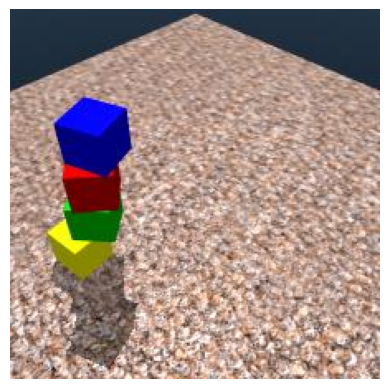

In [ ]:
img, img_array, label = get_sample('train', 173, (224,224), class_label = TOTAL_HEIGHT)
print(label)
show_img(img)

In [89]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define online augmentations
datagen = ImageDataGenerator(
    rotation_range=10,       # Randomly rotate images
    zoom_range=0.1,          # Zoom in/out images
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill empty pixels after transformations
)
# Define the generator function
def data_generator(label_df, data_split, original_img_type, batch_size, img_size, dtype = "float", shuffle=False, class_label = STABLE_HEIGHT, augmentations = [], online_augmentation=False):
    img_ids = label_df['id'].values.copy() 
    
    # Combine original and augmented images
    image_version = [original_img_type] + augmentations
    #for f in [data_split] + augmentations:
        #for img_id in img_ids:
            #all_image_paths.append((f, img_id))
    num_samples = len(img_ids)
    
    while True:
        all_image_paths = []
        for img_id in img_ids:
            version = random.choice(image_version)
            all_image_paths.append((version, img_id))
        if shuffle:
            np.random.shuffle(all_image_paths)
        for offset in range(0, num_samples, batch_size):
            batch_paths = all_image_paths[offset:offset + batch_size]

            batch_images = []
            batch_labels = []

            for f, img_id in batch_paths:
                # Load image and preprocess it
                img_path = os.path.join(project_path, f'COMP90086_2024_Project_{data_split}/{f}', f'{img_id}.jpg')
                img = image.load_img(img_path, target_size=img_size)
                img_array = image.img_to_array(img)
                img_array = centralize_object(img_array)
                if online_augmentation: 
                    img_array = datagen.random_transform(img_array)
                if dtype == "float": 
                    img_array = img_array / 255.0  # Normalize the image array
                if dtype == "int":
                    img_array = img_array.astype(np.uint8)

                # Retrieve the label
                label = get_label(label_df, img_id, class_label=class_label)

                batch_images.append(img_array)
                batch_labels.append(label)

            # Convert lists to numpy arrays
            batch_images = np.array(batch_images)
            batch_labels = np.array(batch_labels)

            # Ensure labels are reshaped properly for binary classification
            if class_label == IS_STABLE: 
                batch_labels = batch_labels.reshape(-1, 1)  # Shape should be (batch_size, 1)

            yield batch_images, batch_labels


# Prepare data for model training.
def prepare_data(original_img_type, dtype="float", class_label = STABLE_HEIGHT, batch_size=16, train_augmentations = [], oversample = True, online_augmentation=True): 
    # Load the label CSVs
    label_dfs = {data_split: get_label_df(data_split) for data_split in ['train', 'test']}
    
    # Split train/dev
    train_df, dev_df = train_test_split(label_dfs['train'], test_size=0.2, random_state=random_state)
    label_dfs['train'] = train_df
    label_dfs['dev'] = dev_df


    # Create train and validation generators
    img_size = (224, 224)

    # settings depending on whether to perform binary-classification
    activation = 'sigmoid' if class_label == IS_STABLE else 'softmax'
    loss = 'binary_crossentropy' if class_label == IS_STABLE else 'sparse_categorical_crossentropy'

    # Sample from train_df to have equal distribution of class labels
    if class_label == IS_STABLE: 
        n_class = 1
        class_column = IS_STABLE
        label_dfs['train'][IS_STABLE] = (label_dfs['train'][TOTAL_HEIGHT] == label_dfs['train'][STABLE_HEIGHT])
        
    else: 
        class_column = class_label
        class_labels = label_dfs['train'][class_column].unique()
        n_class = len(class_labels)
        
        
    if oversample: 
        # oversampling
        X = label_dfs['train'].drop(columns=[class_column])
        y = label_dfs['train'][class_column]

        # Apply random oversampling
        ros = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = ros.fit_resample(X, y)

        # Combine the resampled data
        label_dfs['train'] = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)
    

    train_generator = data_generator(label_dfs['train'], 'train', original_img_type, batch_size, img_size, dtype=dtype, shuffle=True, class_label = class_label, augmentations=train_augmentations, online_augmentation=online_augmentation)
    validation_generator = data_generator(label_dfs['dev'], 'train', original_img_type, batch_size, img_size, dtype=dtype, class_label=class_label)
    return label_dfs, train_generator, validation_generator, activation, loss, n_class

# look at data distribution
def data_distribution(class_label, label_dfs): 
    num_train_sample, num_dev_sample = len(label_dfs['train']), len(label_dfs['dev'])
    if class_label == IS_STABLE: 
        print(f'training dataset has {num_train_sample} samples, dev dataset has {num_dev_sample} samples')
        stable_prop = sum(label_dfs['train'][IS_STABLE])/label_dfs['train'].shape[0]
        print(f'binary distribution: {stable_prop} training data are stable')
        stable_prop = sum(label_dfs['dev'][TOTAL_HEIGHT]==label_dfs['dev'][STABLE_HEIGHT])/label_dfs['dev'].shape[0]
        print(f'binary distribution: {stable_prop} dev data are stable')
    else: 
        print(f'training dataset has {num_train_sample} samples, dev dataset has {num_dev_sample} samples')
        class_counts = label_dfs['train'][class_label].value_counts()
        print(f'{class_label} train distribution: {class_counts/sum(class_counts)}')
        class_counts = label_dfs['dev'][class_label].value_counts()
        print(f'{class_label} dev distribution: {class_counts/sum(class_counts)}')


In [90]:
# current task
class_label = STABLE_HEIGHT
batch_size = 8
train_augmentations = ['train_rm_background_flipped', 'train_rm_background_aspect_ratio', 'train_rm_background_color', 'train_rm_background_rotation']
# Be careful! dtype = "int" for swintransformer, but "float" for others
label_dfs, train_generator, validation_generator, activation, loss, n_class = prepare_data('train_rm_background', "float", class_label, batch_size, train_augmentations)

num_train_sample, num_dev_sample = len(label_dfs['train']), len(label_dfs['dev'])
steps_per_epoch_train = num_train_sample // batch_size
steps_per_epoch_dev = num_dev_sample // batch_size
label_dfs['train'].head(5)

,id,shapeset,type,total_height,instability_type,cam_angle,stable_height
0,177296,1,2,6,1,1,1
1,69840,1,1,3,1,2,1
2,672664,2,2,5,1,1,1
3,787525,2,2,6,2,1,5
4,848168,1,2,5,0,2,5


In [91]:
for j,i in enumerate(train_generator): 
    print(i[0].shape)
    print(np.max(i[0]))
    print(i[1])
    break
label_dfs['train'].head(5)

(8, 224, 224, 3)
1.0
[0 1 4 5 1 0 5 2]


,id,shapeset,type,total_height,instability_type,cam_angle,stable_height
0,177296,1,2,6,1,1,1
1,69840,1,1,3,1,2,1
2,672664,2,2,5,1,1,1
3,787525,2,2,6,2,1,5
4,848168,1,2,5,0,2,5


In [92]:
data_distribution(class_label, label_dfs)

training dataset has 9432 samples, dev dataset has 1536 samples
stable_height train distribution: stable_height
1    0.166667
5    0.166667
2    0.166667
4    0.166667
6    0.166667
3    0.166667
Name: count, dtype: float64
stable_height dev distribution: stable_height
2    0.259115
1    0.226562
3    0.203776
4    0.153646
5    0.108724
6    0.048177
Name: count, dtype: float64


# Evaluation

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from tqdm import tqdm

def test_predict(model, label_dfs, data_split, n_class, dtype="float", class_offset = 1, img_type=None):
    test_preds = {'id': label_dfs[data_split]['id'].values, 'prediction':[]}
    for i in range(class_offset, n_class + class_offset):
        test_preds[f'prob_class_{i}'] = []

    for img_id in tqdm(label_dfs[data_split]['id']):
        img, img_array = get_image(data_split, img_id, (224,224), img_type)
        if dtype == "float": 
            img_array = img_array / 255.0
        if dtype == "int":
            img_array = img_array.astype(np.uint8)
        preds = model.predict(img_array, verbose=0)
        predicted_class = np.argmax(preds, axis=1)[0] + class_offset
        test_preds['prediction'].append(predicted_class)
        for i in range(n_class):
            test_preds[f'prob_class_{i+class_offset}'].append(preds[0][i])

    test_preds = pd.DataFrame.from_dict(test_preds,orient='index').transpose()
    test_preds['id'] = test_preds['id'].astype(int)
    test_preds['prediction'] = test_preds['prediction'].astype(int)
    return test_preds

def conf_matrix(model, label_dfs, data_split, n_class, class_offset = 1, class_label=STABLE_HEIGHT, img_type=None, dtype="float"): 
    pred_result = test_predict(model, label_dfs, data_split, n_class, dtype, class_offset, img_type)
    predicted_classes = (pred_result['prediction'] - class_offset).values
    true_classes = (label_dfs[data_split][class_label] - class_offset).values
    pred_result['label'] = true_classes
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    # normalize the confusion matrix by sum of each row (true label)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # Plot raw counts confusion matrix
    disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp1.plot(ax=ax[0], values_format='d')
    ax[0].set_title('Confusion Matrix (Counts)')

    # Plot normalized confusion matrix
    disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized)
    disp2.plot(ax=ax[1], values_format=".2f")
    ax[1].set_title('Confusion Matrix (Normalized)')

    plt.tight_layout()
    plt.show()

    print(classification_report(true_classes, predicted_classes))
    return pred_result

def plot_history(history): 
    plot_acc(history)
    plot_loss(history)

def plot_acc(history): 
    plt.plot(history['accuracy'], label='Train')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Training and validating accuracy')
    plt.grid(axis='y')
    plt.legend(loc='lower right')
    plt.show()

def plot_loss(history): 
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training and validating loss')
    plt.grid(axis='y')
    plt.legend(loc='lower right')
    plt.show()

# Classification

In [75]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

## Stacking

In [ ]:
from scipy.stats import mode
import re

def hard_voting(row, img_types):
    predictions = [row[f'prediction_{t}'] for t in img_types]
    mode_result = mode(predictions)
    return mode_result.mode if mode_result.count > 0 else None

def average_probabilities(row, n_class, img_types):
    probs = []
    # Iterate over each class, compute the mean of the relevant columns
    for i in range(1, n_class + 1):
        columns = [f'prob_class_{i}_{t}' for t in img_types]
        mean_prob = row[columns].mean() if columns else 0
        probs.append(mean_prob)
    
    return probs


def stacking_predict(model, label_dfs, data_split, n_class, offset, img_types, dtype="float"):
    if len(img_types) < 2: return None
    all_predictions = dict()
    # perform predictions on different types of data augmentation
    for t in img_types: 
        all_predictions[t] = test_predict(model, label_dfs, data_split, n_class, dtype, offset, t)
        if STABLE_HEIGHT in label_dfs[data_split].columns: 
            all_predictions[t]['label'] = label_dfs[data_split][STABLE_HEIGHT].values
        all_predictions[t] = all_predictions[t].rename(columns=lambda x: f'{x}_{t}' if x != 'id' else x)
    label_1, label_2 = img_types[0], img_types[1]
    # merge the predictions
    df_combined = all_predictions[label_1].merge(all_predictions[label_2], on='id')
    for t in img_types[2:]:
        df_combined = df_combined.merge(all_predictions[t], on='id')
    # calculate hard/soft voting predictions
    df_combined['hard_voted_prediction'] = df_combined.apply(hard_voting, axis=1, args=(img_types,))
    final_prob_class_cols = [f'prob_class_{i+offset}' for i in range(n_class)]
    df_combined[final_prob_class_cols] = df_combined.apply(average_probabilities, axis=1, args=(n_class, img_types), result_type='expand')
    df_combined['soft_voted_prediction'] = df_combined[final_prob_class_cols].idxmax(axis=1).str.replace('prob_class_', '').astype(int)
    return df_combined

## ResNet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam, RMSprop

# Load the ResNet50 model without the top layers (fully connected layers), using ImageNet weights
base_model = ResNet50(weights='imagenet', input_shape=[224, 224, 3], include_top=False)
for layer in base_model.layers:
    layer.trainable = True

# Add new custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(units = 1536, activation='relu') (x)
x = Dense(units = 256, activation='relu', kernel_regularizer=l2(0.01)) (x)
x = Dropout(rate = 0.3) (x)

predictions = Dense(n_class, activation=activation)(x) 

# Define the new model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss=loss, metrics=['accuracy'])

# Print summary to see the new architecture
model.summary()

In [94]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    os.path.join(project_path, 'resnet_direct.keras'),   # Filepath to save the model
    monitor='val_accuracy',   # Monitor validation accuracy
    save_best_only=True,  # Only save the model if val_accuracy improves
    mode='max',  # Mode should be 'max' to save the model when val_accuracy increases
    verbose=1    # Print out info when saving
)


In [ ]:
# current task
class_label = STABLE_HEIGHT
batch_size = 8
train_augmentations = ['train_rm_background_flipped', 'train_rm_background_aspect_ratio', 'train_rm_background_color', 'train_rm_background_rotation']
# Be careful! dtype = "int" for swintransformer, but "float" for others
label_dfs, train_generator, validation_generator, activation, loss, n_class = prepare_data('train_rm_background', "float", class_label, batch_size, train_augmentations)

num_train_sample, num_dev_sample = len(label_dfs['train']), len(label_dfs['dev'])
steps_per_epoch_train = num_train_sample // batch_size
steps_per_epoch_dev = num_dev_sample // batch_size

In [ ]:
# Train the model with the checkpoint callback
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_dev,
    epochs=10,
    callbacks=[checkpoint]  
)

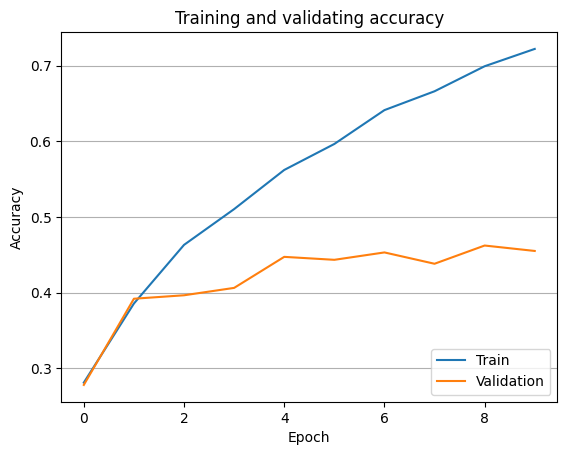

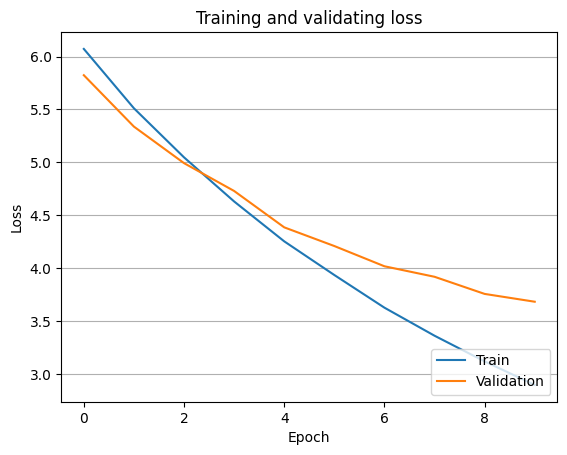

In [112]:
plot_history(history.history)

100%|██████████| 1536/1536 [01:36<00:00, 15.86it/s]


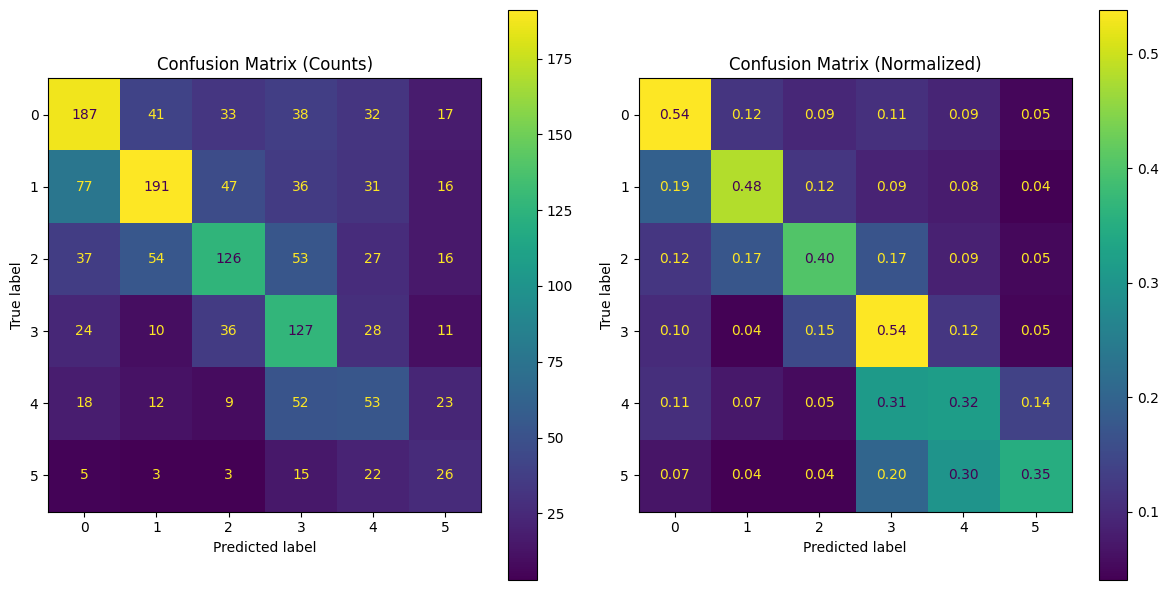

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       348
           1       0.61      0.48      0.54       398
           2       0.50      0.40      0.44       313
           3       0.40      0.54      0.46       236
           4       0.27      0.32      0.29       167
           5       0.24      0.35      0.28        74

    accuracy                           0.46      1536
   macro avg       0.43      0.44      0.43      1536
weighted avg       0.48      0.46      0.47      1536



,id,prediction,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6,label
0,369575,3,0.018171,0.016337,0.843270,0.117201,3.031995e-03,0.001989,2
1,602724,3,0.166015,0.095554,0.516361,0.197293,1.352591e-02,0.011250,1
2,269106,1,0.509565,0.207054,0.236594,0.028060,1.768070e-02,0.001046,2
3,212749,1,0.621610,0.051756,0.069841,0.246336,5.909860e-03,0.004547,2
4,324537,4,0.005603,0.004525,0.010021,0.861433,1.183936e-01,0.000025,1
...,...,...,...,...,...,...,...,...,...
1531,863017,1,0.999966,0.000024,0.000005,0.000003,2.089586e-07,0.000001,0
1532,992184,2,0.448552,0.517571,0.020002,0.009380,2.558665e-03,0.001937,0
1533,6882,6,0.013295,0.005893,0.015795,0.119720,2.963595e-02,0.815662,5
1534,757985,2,0.120745,0.450459,0.422110,0.004059,1.192036e-03,0.001435,2


In [113]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
best_model = load_model(os.path.join(project_path, 'resnet_direct.keras'))
conf_matrix(best_model, label_dfs, 'dev', n_class, class_offset=1, class_label=class_label, img_type='train_rm_background')

In [115]:
img_types = ['rm_background','rm_background_flipped','rm_background_color','rm_background_rotation','rm_background_aspect_ratio']
dev_pred = stacking_predict(best_model, label_dfs, 'dev', 6, 1, ['train_'+t for t in img_types])
test_pred = stacking_predict(best_model, label_dfs, 'test', 6, 1, ['test_'+t for t in img_types])
print(sum(dev_pred['soft_voted_prediction']==dev_pred['label_train_rm_background'])/len(dev_pred))
test_preds = test_pred[['id','soft_voted_prediction']].rename(columns={'soft_voted_prediction':'stable_height'})
test_preds.to_csv(os.path.join(project_path, 'COMP90086_2024_Project_test', 'prediction_resnet_direct.csv'), index=False)

100%|██████████| 1920/1920 [01:56<00:00, 16.46it/s]


0.4765625


## InceptionV3

In [ ]:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

# Load the InceptionV3 model without the top layers (fully connected layers), using ImageNet weights
base_model = tf.keras.applications.InceptionV3(weights='imagenet', input_shape=[224, 224, 3], include_top=False)

# Add new custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(units = 1536, activation='relu') (x)
x = Dense(units = 256, activation='relu', kernel_regularizer=l2(0.01)) (x)
x = Dropout(rate = 0.3) (x)
predictions = Dense(n_class, activation=activation)(x) 

# Define the new model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss=loss, metrics=['accuracy'])

# Print summary to see the new architecture
model.summary()

In [24]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    os.path.join(project_path, 'inceptionv3_direct.keras'),   # Filepath to save the model
    monitor='val_accuracy',   # Monitor validation accuracy
    save_best_only=True,  # Only save the model if val_accuracy improves
    mode='max',  # Mode should be 'max' to save the model when val_accuracy increases
    verbose=1    # Print out info when saving
)

In [ ]:
# current task
class_label = STABLE_HEIGHT
batch_size = 8
train_augmentations = ['train_rm_background_flipped', 'train_rm_background_aspect_ratio', 'train_rm_background_color', 'train_rm_background_rotation']
# Be careful! dtype = "int" for swintransformer, but "float" for others
label_dfs, train_generator, validation_generator, activation, loss, n_class = prepare_data('train_rm_background', "float", class_label, batch_size, train_augmentations)

num_train_sample, num_dev_sample = len(label_dfs['train']), len(label_dfs['dev'])
steps_per_epoch_train = num_train_sample // batch_size
steps_per_epoch_dev = num_dev_sample // batch_size
label_dfs['train'].head(5)

In [ ]:
# Train the model 
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_dev,
    epochs=10,
    callbacks=[checkpoint]  
)

100%|██████████| 1536/1536 [01:23<00:00, 18.40it/s]


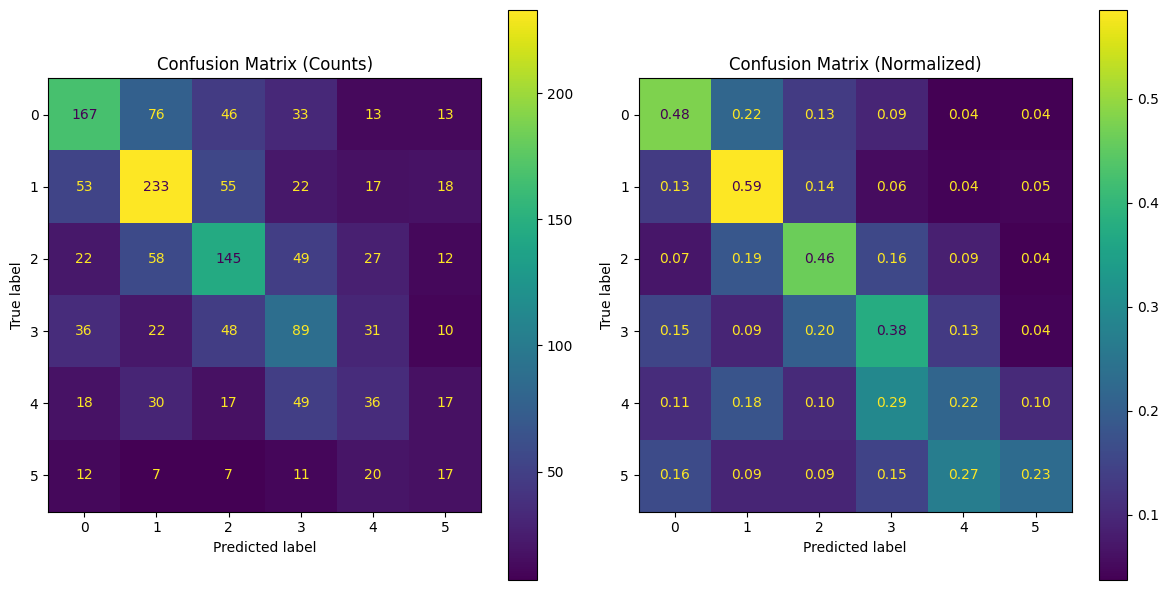

              precision    recall  f1-score   support

           0       0.54      0.48      0.51       348
           1       0.55      0.59      0.57       398
           2       0.46      0.46      0.46       313
           3       0.35      0.38      0.36       236
           4       0.25      0.22      0.23       167
           5       0.20      0.23      0.21        74

    accuracy                           0.45      1536
   macro avg       0.39      0.39      0.39      1536
weighted avg       0.45      0.45      0.45      1536



In [31]:
from tensorflow.keras.models import load_model
best_model = load_model(os.path.join(project_path, 'inceptionv3_direct.keras'))
dev_result_best = conf_matrix(best_model, label_dfs, 'dev', n_class, class_offset=1, class_label=class_label, img_type='train_rm_background')

In [33]:
img_types = ['rm_background','rm_background_flipped','rm_background_color','rm_background_rotation','rm_background_aspect_ratio']
dev_pred = stacking_predict(best_model, label_dfs, 'dev', 6, 1, ['train_'+t for t in img_types])
test_pred = stacking_predict(best_model, label_dfs, 'test', 6, 1, ['test_'+t for t in img_types])

100%|██████████| 1920/1920 [01:47<00:00, 17.91it/s]


In [34]:
sum(dev_pred['soft_voted_prediction']==dev_pred['label_train_rm_background'])/len(dev_pred)

0.4609375

In [35]:
test_preds = test_pred[['id','soft_voted_prediction']].rename(columns={'soft_voted_prediction':'stable_height'})
test_preds.to_csv(os.path.join(project_path, 'COMP90086_2024_Project_test', 'prediction_incep_direct.csv'), index=False)

## Swin Transformer

In [42]:
from tfswin import SwinTransformerTiny224#SwinTransformerV2Tiny256 #
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

In [43]:
def build_swinformer_model(n_class, activation): 
    inputs = layers.Input(shape=(224, 224, 3), dtype="uint8")
    x = SwinTransformerTiny224(include_top=False)(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 256, activation='relu', kernel_regularizer=l2(0.0001)) (x)
    x = Dropout(rate = 0.3) (x)
    # x = Flatten()(x)
    # x = Dropout(rate = 0.3) (x)
    predictions = Dense(n_class, activation=activation)(x) 
    model = Model(inputs=inputs, outputs=predictions)
    return model

model = build_swinformer_model(n_class, activation)
model.compile(optimizer=Adam(learning_rate=0.00001), loss=loss, metrics=['accuracy'])

# Print summary to see the new architecture
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_tiny_224 (Functional)      │ (None, 7, 7, 768)      │    27,519,354 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,716,475 (105.73 MB)

 Trainable params: 27,716,475 (105.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# current task
class_label = STABLE_HEIGHT
batch_size = 8
train_augmentations = ['train_rm_background_flipped', 'train_rm_background_aspect_ratio', 'train_rm_background_color', 'train_rm_background_rotation']
# Be careful! dtype = "int" for swintransformer, but "float" for others
label_dfs, train_generator, validation_generator, activation, loss, n_class = prepare_data('train_rm_background', "int", class_label, batch_size, train_augmentations)

num_train_sample, num_dev_sample = len(label_dfs['train']), len(label_dfs['dev'])
steps_per_epoch_train = num_train_sample // batch_size
steps_per_epoch_dev = num_dev_sample // batch_size
label_dfs['train'].head(5)

In [ ]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    os.path.join(project_path, 'swinformer_direct.keras'),   # Filepath to save the model
    monitor='val_accuracy',   # Monitor validation accuracy
    save_best_only=True,  # Only save the model if val_accuracy improves
    mode='max',  # Mode should be 'max' to save the model when val_accuracy increases
    verbose=1    # Print out info when saving
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_dev,
    epochs=10,
    callbacks=[checkpoint]  
)


In [60]:
best_model = build_swinformer_model(n_class, activation)
best_model.load_weights("swinformer_direct.keras")

100%|██████████| 1536/1536 [03:59<00:00,  6.43it/s]


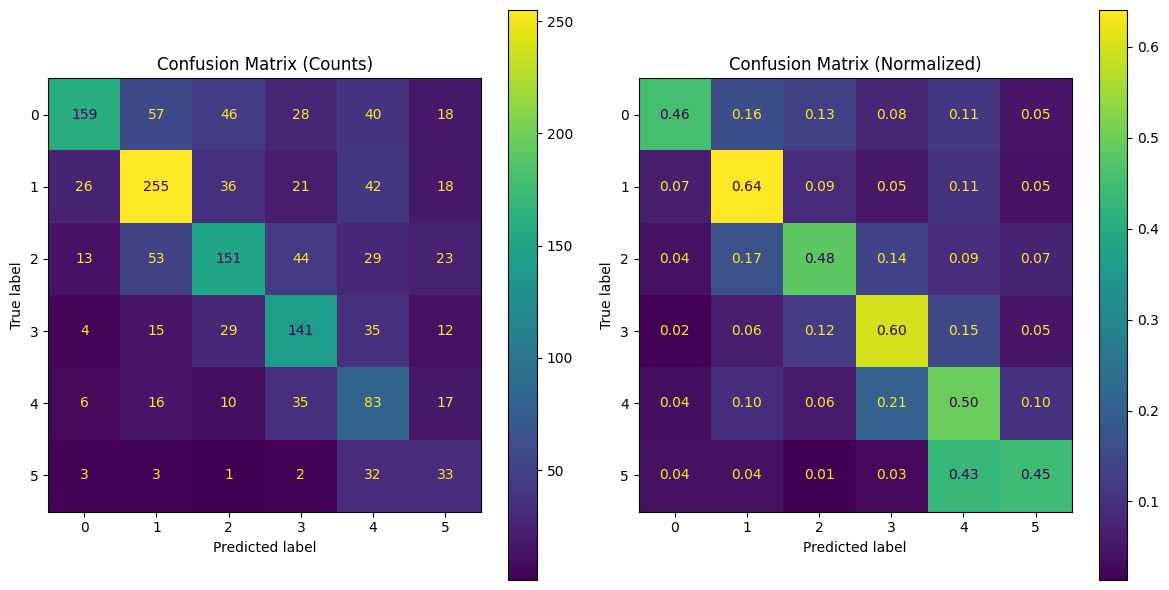

              precision    recall  f1-score   support

           0       0.75      0.46      0.57       348
           1       0.64      0.64      0.64       398
           2       0.55      0.48      0.52       313
           3       0.52      0.60      0.56       236
           4       0.32      0.50      0.39       167
           5       0.27      0.45      0.34        74

    accuracy                           0.54      1536
   macro avg       0.51      0.52      0.50      1536
weighted avg       0.58      0.54      0.54      1536



In [ ]:
dev_result_best = conf_matrix(best_model, label_dfs, 'dev', n_class, class_offset=1, class_label=class_label, img_type='train_rm_background', dtype="int")

In [ ]:
sum(dev_result_best['prediction'] == (dev_result_best['label']+1))/len(dev_result_best)

0.53515625

In [73]:
test_preds = test_predict(best_model, label_dfs, 'test', 6, 'int', 1, "test_rm_background")
test_preds = test_preds[['id','prediction']].rename(columns={'prediction':'stable_height'})
test_preds.to_csv(os.path.join(project_path, 'COMP90086_2024_Project_test', 'prediction_swin_direct.csv'), index=False)

100%|██████████| 1920/1920 [05:09<00:00,  6.21it/s]
